# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
### To start off let's do a basic data summary.
import numpy as np

# TODO: number of training examples
n_train = X_train.shape[0]

# TODO: number of testing examples
n_test = X_test.shape[0]

# TODO: what's the shape of an image?
image_shape = X_train[0].shape[0]

# TODO: how many classes are in the dataset
n_classes = np.unique(y_train).size

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = 32
Number of classes = 43


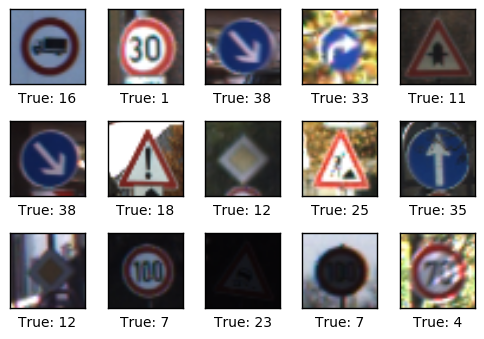

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 15
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 5)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        # ax.imshow(images[i].reshape(img_shape), cmap='binary')
        ax.imshow(images[i], cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    
# Get the first images from the test-set.
images = X_test[0:15]

# Get the true classes for those images.
cls_true = y_test[0:15]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import time
from datetime import timedelta
import math


def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    shape = [filter_size, filter_size, num_input_channels, num_filters]
    weights = new_weights(shape=shape)
    biases = new_biases(length=num_filters)
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')
    layer += biases
    # Use pooling to down-sample the image resolution?
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')
    layer = tf.nn.relu(layer)
    return layer, weights

def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features

def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    layer = tf.matmul(input, weights) + biases
    if use_relu:
        layer = tf.nn.relu(layer)
    return layer

tf.__version__

# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.


# X_train, y_train = train['features'], train['labels']
# X_test, y_test = test['features'], test['labels']

# number of training examples
n_train = X_train.shape[0]

# number of testing examples
n_test = X_test.shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)

# train_features = X_train
# train_labels = y_train

test_features = X_test
test_labels = y_test

print('test_labels', np.unique(test_labels) )

# Get randomized datasets for training and validation
train_features, valid_features, train_labels, valid_labels = train_test_split(
    X_train, # train_features,
    y_train, # train_labels,
    test_size=0.05,
    random_state=832289)

print('Training features and labels randomized and split.')
print("Number of training features =", train_features.shape[0])
print("Number of training labels =", train_labels.shape[0])
print("Number of validating features =", valid_features.shape[0])
print("Number of validating labels =", valid_labels.shape[0])
print("Number of testing features =", test_features.shape[0])
print("Number of testing labels =", test_labels.shape[0])

features_count = 1024 # 32x32
labels_count = 43

# Features and labels tensors
features = tf.placeholder(tf.float32)
labels = tf.placeholder(tf.float32)

# data.test.cls = np.argmax(data.test.labels, axis=1)
data_test_cls = np.argmax(test_labels)

img_size = 32

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 3

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size * num_channels

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of classes, one class for each of 10 digits.
num_classes = 43

  

input_tensor = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='input_tensor')

input_image_tensor = tf.reshape(input_tensor, [-1, img_size, img_size, num_channels])

input_true_tensor = tf.placeholder(tf.float32, shape=[None, num_classes], name='input_true_tensor')

input_true_cls_tensor = tf.argmax(input_true_tensor, dimension=1)

#print('x.shape: ', x.shape)
#print('x_image.shape: ', x_image.shape)
#print('y_true.shape: ', y_true.shape)
#print('y_true_cls.shape: ', y_true_cls.shape)

layer_conv1, weights_conv1 = \
    new_conv_layer(input=input_image_tensor,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)
    
print('layer_conv1: ', layer_conv1)

layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)
    
# layer_conv2
print('layer_conv2: ', layer_conv2)

layer_flat, num_features = flatten_layer(layer_conv2)

# layer_flat
print('layer_flat: ', layer_flat)

# num_features
print('num_features: ', num_features)

layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

# layer_fc1
print('layer_fc1: ', layer_fc1)


layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

# layer_fc2
print('layer_fc2: ', layer_fc2)

y_pred = tf.nn.softmax(layer_fc2)

y_pred_cls = tf.argmax(y_pred, dimension=1)


cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=input_true_tensor)

cost = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

correct_prediction = tf.equal(y_pred_cls, input_true_cls_tensor)

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

session = tf.Session()
session.run(tf.initialize_all_variables())



Number of training examples = 39209
Number of testing examples = 12630
test_labels [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]
Training features and labels randomized and split.
Number of training features = 37248
Number of training labels = 37248
Number of validating features = 1961
Number of validating labels = 1961
Number of testing features = 12630
Number of testing labels = 12630
layer_conv1:  Tensor("Relu:0", shape=(?, 16, 16, 16), dtype=float32)
layer_conv2:  Tensor("Relu_1:0", shape=(?, 8, 8, 36), dtype=float32)
layer_flat:  Tensor("Reshape_1:0", shape=(?, 2304), dtype=float32)
num_features:  2304
layer_fc1:  Tensor("Relu_2:0", shape=(?, 128), dtype=float32)
layer_fc2:  Tensor("add_3:0", shape=(?, 43), dtype=float32)


In [10]:
from sklearn.preprocessing import OneHotEncoder

def OHE_labels(Y_tr,N_classes):
    OHC = OneHotEncoder()
    
    Y_ohc = OHC.fit(np.arange(N_classes).reshape(-1, 1))
    Y_labels = Y_ohc.transform(Y_tr.reshape(-1, 1)).toarray()
    return Y_labels

labels_train = OHE_labels(y_train,43)
labels_test = OHE_labels(y_test,43)  

train_batch_size = 64
total_iterations = 0

num_iterations = 600

print('num_iterations: ', num_iterations)

# Start-time used for printing time-usage below.
start_time = time.time()

print('train_features.shape: ', train_features.shape)
print('labels_train.shape: ', labels_train.shape)

print('labels_train[0:3]: ', labels_train[0:3])

def next_batch(x, y, batch_index, batch_size):
    start = batch_index
    end = start + batch_size
    images = x[start:end, :]
#    print('(1)images.shape: ', images.shape)
    #assert images.shape[3] == 1
    images = images.reshape(images.shape[0],
        images.shape[1] * images.shape[2] * images.shape[3])
#   print('(2)images.shape: ', images.shape)
    return images, y[start:end]

def next_random_batch(x, y, batch_index, batch_size):
#     start = batch_index
#     end = start + batch_size
#     rand_var_1 = tf.Variable(tf.random_uniform([5], 0, 10, dtype=tf.int32, seed=0))

    # tf.random_crop(value, size, seed=None, name=None)
    rand_images = tf.random_crop(x, batch_size, seed=None, name=None)
#     images = x[start:end, :]  
    print('(1)images.shape: ', rand_images.shape)
    #assert images.shape[3] == 1
    images = images.reshape(images.shape[0],
        images.shape[1] * images.shape[2] * images.shape[3])
    print('(2)images.shape: ', images.shape)
    return images, y[start:end]


rand_images = tf.random_crop(train_features, train_batch_size, seed=None, name=None)
print('(1)rand_images.shape: ', rand_images.shape)


batch_index = 0

for i in range(total_iterations,
               total_iterations + num_iterations):

#     print('batch_index: ', batch_index)

    # Get a batch of training examples.
    # x_batch now holds a batch of images and
    # y_true_batch are the true labels for those images.
    # x_batch, y_true_batch = data.train.next_batch(train_batch_size)
    x_batch, y_true_batch = next_batch(train_features, labels_train, batch_index, train_batch_size)

    batch_index += train_batch_size

#     print('x_batch.shape: ', x_batch.shape)
#     print('y_true_batch.shape: ', y_true_batch.shape)

    # Put the batch into a dict with the proper names
    # for placeholder variables in the TensorFlow graph.
    feed_dict_train = {input_tensor: x_batch,
                       input_true_tensor: y_true_batch}

    # Run the optimizer using this batch of training data.
    # TensorFlow assigns the variables in feed_dict_train
    # to the placeholder variables and then runs the optimizer.
    session.run(optimizer, feed_dict=feed_dict_train)

    # Print status every 100 iterations.
    if i % 3 == 0:
        # Calculate the accuracy on the training-set.
#         acc = session.run(accuracy, feed_dict=feed_dict_train)

        # Message for printing.
        msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

        # Print it.
        print(msg.format(i + 1, acc))

# Update the total number of iterations performed.
total_iterations += num_iterations

# Ending time.
end_time = time.time()

# Difference between start and end-times.
time_dif = end_time - start_time

# Print the time-usage.
print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))


num_iterations:  600
train_features.shape:  (37248, 32, 32, 3)
labels_train.shape:  (39209, 43)
labels_train[0:3]:  [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]]


ValueError: Shape () must have rank 1

In [ ]:

train_batch_size = 64


# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        # x_batch, y_true_batch = data.train.next_batch(train_batch_size)
        x_batch, y_true_batch = X_train.next_batch(train_batch_size)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
    
    
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    #num_test = len(data.test.images)
    num_test = len(X_test)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    print('X_test:', len(X_test), ', y_test:', len(y_test))
    
    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)
        
        print('i:', i, ', j:', j)

        # Get the images from the test-set between index i and j.
        #images = data.test.images[i:j, :]
        images = X_test[i:j, :]

        # Get the associated labels.
        #labels = data.test.labels[i:j, :]
        #train_labels
        labels = y_test[i:j]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    #cls_true = data.test.cls
    cls_true = data_test_cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)
        
        
#print_test_accuracy()        

"""
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

print("- data.test.images.shape:\t\t{}", data.test.images.shape)
print("- data.test.labels.shape:\t\t{}", data.test.labels.shape)

#print("- data.train.next_batch:\t\t{}".format(len(data.train.next_batch)))
#print("- data.train.next_batch:\t\t{}", data.train.next_batch)
"""

print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)

from tensorflow.contrib.learn.python.learn.datasets.mnist import DataSet
train_images = X_train
train_labels = y_train

print('train_images.shape[0]: ', train_images.shape[0])
print('train_images.shape[1]: ', train_images.shape[1])
print('train_images.shape[2]: ', train_images.shape[2])


#des = np.array(des,np.float32).reshape(1, len(des))
#train_images = train_images.reshape(train_images.shape[0], train_images.shape[1] * train_images.shape[2])

#train = DataSet(train_images, train_labels, dtype=tf.float32, reshape=True)

#print("Size of:")
#print("- Training-set-images:\t\t{}".format(len(train.images)))
#print("- Training-set-labels:\t\t{}".format(len(train.labels)))

x_batch, y_true_batch = train.next_batch(train_batch_size)
print('x_batch.shape: ', x_batch.shape)
print('y_true_batch.shape: ', y_true_batch.shape)

#optimize(num_iterations=1)


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

In [3]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm import tqdm

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

# number of training examples
n_train = X_train.shape[0]

# number of testing examples
n_test = X_test.shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)

# train_features = X_train
# train_labels = y_train

test_features = X_test
test_labels = y_test

# Get randomized datasets for training and validation
train_features, valid_features, train_labels, valid_labels = train_test_split(
    X_train, # train_features,
    y_train, # train_labels,
    test_size=0.05,
    random_state=832289)

print('Training features and labels randomized and split.')
print("Number of training features =", train_features.shape[0])
print("Number of training labels =", train_labels.shape[0])
print("Number of validating features =", valid_features.shape[0])
print("Number of validating labels =", valid_labels.shape[0])
print("Number of testing features =", test_features.shape[0])
print("Number of training labels =", test_labels.shape[0])

features_count = 1024
labels_count = 43

# Features and labels tensors
features = tf.placeholder(tf.float32)
labels = tf.placeholder(tf.float32)

# Weights and biases tensors
weights = tf.Variable(tf.truncated_normal([features_count, labels_count]), name="weights")
biases = tf.Variable(tf.zeros([labels_count]), name="biases")


tf.reshape(conv3, [-1, conv3_shape[1] * conv3_shape[2] * conv3_shape[3]])



# Feed dicts for training, validation, and test session
train_feed_dict = {features: train_features, labels: train_labels}
valid_feed_dict = {features: valid_features, labels: valid_labels}
test_feed_dict = {features: test_features, labels: test_labels}

# Linear Function WX + b
print('Linear Function: WX + b')
logits = tf.matmul(features, weights) + biases

print('Softmax.')
prediction = tf.nn.softmax(logits)

# Cross entropy
print('Cross entropy.')
# cross_entropy = -tf.reduce_sum(labels * tf.log(prediction), reduction_indices=1)
cross_entropy = -tf.reduce_sum(labels * tf.log(tf.clip_by_value(prediction,1e-10,1.0)), reduction_indices=1)

# Training loss
print('Training loss.')
loss = tf.reduce_mean(cross_entropy)

# Create an operation that initializes all variables
print('Create an operation that initializes all variables.')
init = tf.initialize_all_variables()

# Test Cases
with tf.Session() as session:
    print('Session run(init)')
    session.run(init)
    print('Session run(loss, feed_dict=train_feed_dict)')
    session.run(loss, feed_dict=train_feed_dict)
    print('Session run(loss, feed_dict=valid_feed_dict)')
    session.run(loss, feed_dict=valid_feed_dict)
    print('Session run(loss, feed_dict=test_feed_dict)')
    session.run(loss, feed_dict=test_feed_dict)
    print('Session run(biases)')
    biases_data = session.run(biases)

assert not np.count_nonzero(biases_data), 'biases must be zeros'

print('Tests Passed!')

Number of training examples = 39209
Number of testing examples = 12630
Training features and labels randomized and split.
Number of training features = 37248
Number of training labels = 37248
Number of validating features = 1961
Number of validating labels = 1961
Number of testing features = 12630
Number of training labels = 12630
Linear Function: WX + b
Softmax.
Cross entropy.
Training loss.
Create an operation that initializes all variables.
Session run(init)
Session run(loss, feed_dict=train_feed_dict)


InvalidArgumentError: In[0] is not a matrix
	 [[Node: MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_Placeholder_0, weights/read)]]

Caused by op 'MatMul', defined at:
  File "//anaconda/envs/CarND-TensorFlow-Lab/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "//anaconda/envs/CarND-TensorFlow-Lab/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "//anaconda/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "//anaconda/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "//anaconda/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "//anaconda/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "//anaconda/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "//anaconda/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "//anaconda/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "//anaconda/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "//anaconda/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "//anaconda/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "//anaconda/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "//anaconda/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "//anaconda/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "//anaconda/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "//anaconda/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "//anaconda/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "//anaconda/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "//anaconda/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-005ea15ca0c9>", line 61, in <module>
    logits = tf.matmul(features, weights) + biases
  File "//anaconda/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/tensorflow/python/ops/math_ops.py", line 1398, in matmul
    name=name)
  File "//anaconda/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/tensorflow/python/ops/gen_math_ops.py", line 1348, in _mat_mul
    transpose_b=transpose_b, name=name)
  File "//anaconda/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 749, in apply_op
    op_def=op_def)
  File "//anaconda/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2380, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "//anaconda/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1298, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): In[0] is not a matrix
	 [[Node: MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_Placeholder_0, weights/read)]]


### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

In [6]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [5]:
### Train your model here.
### Feel free to use as many code cells as needed.





### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [3]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [4]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.